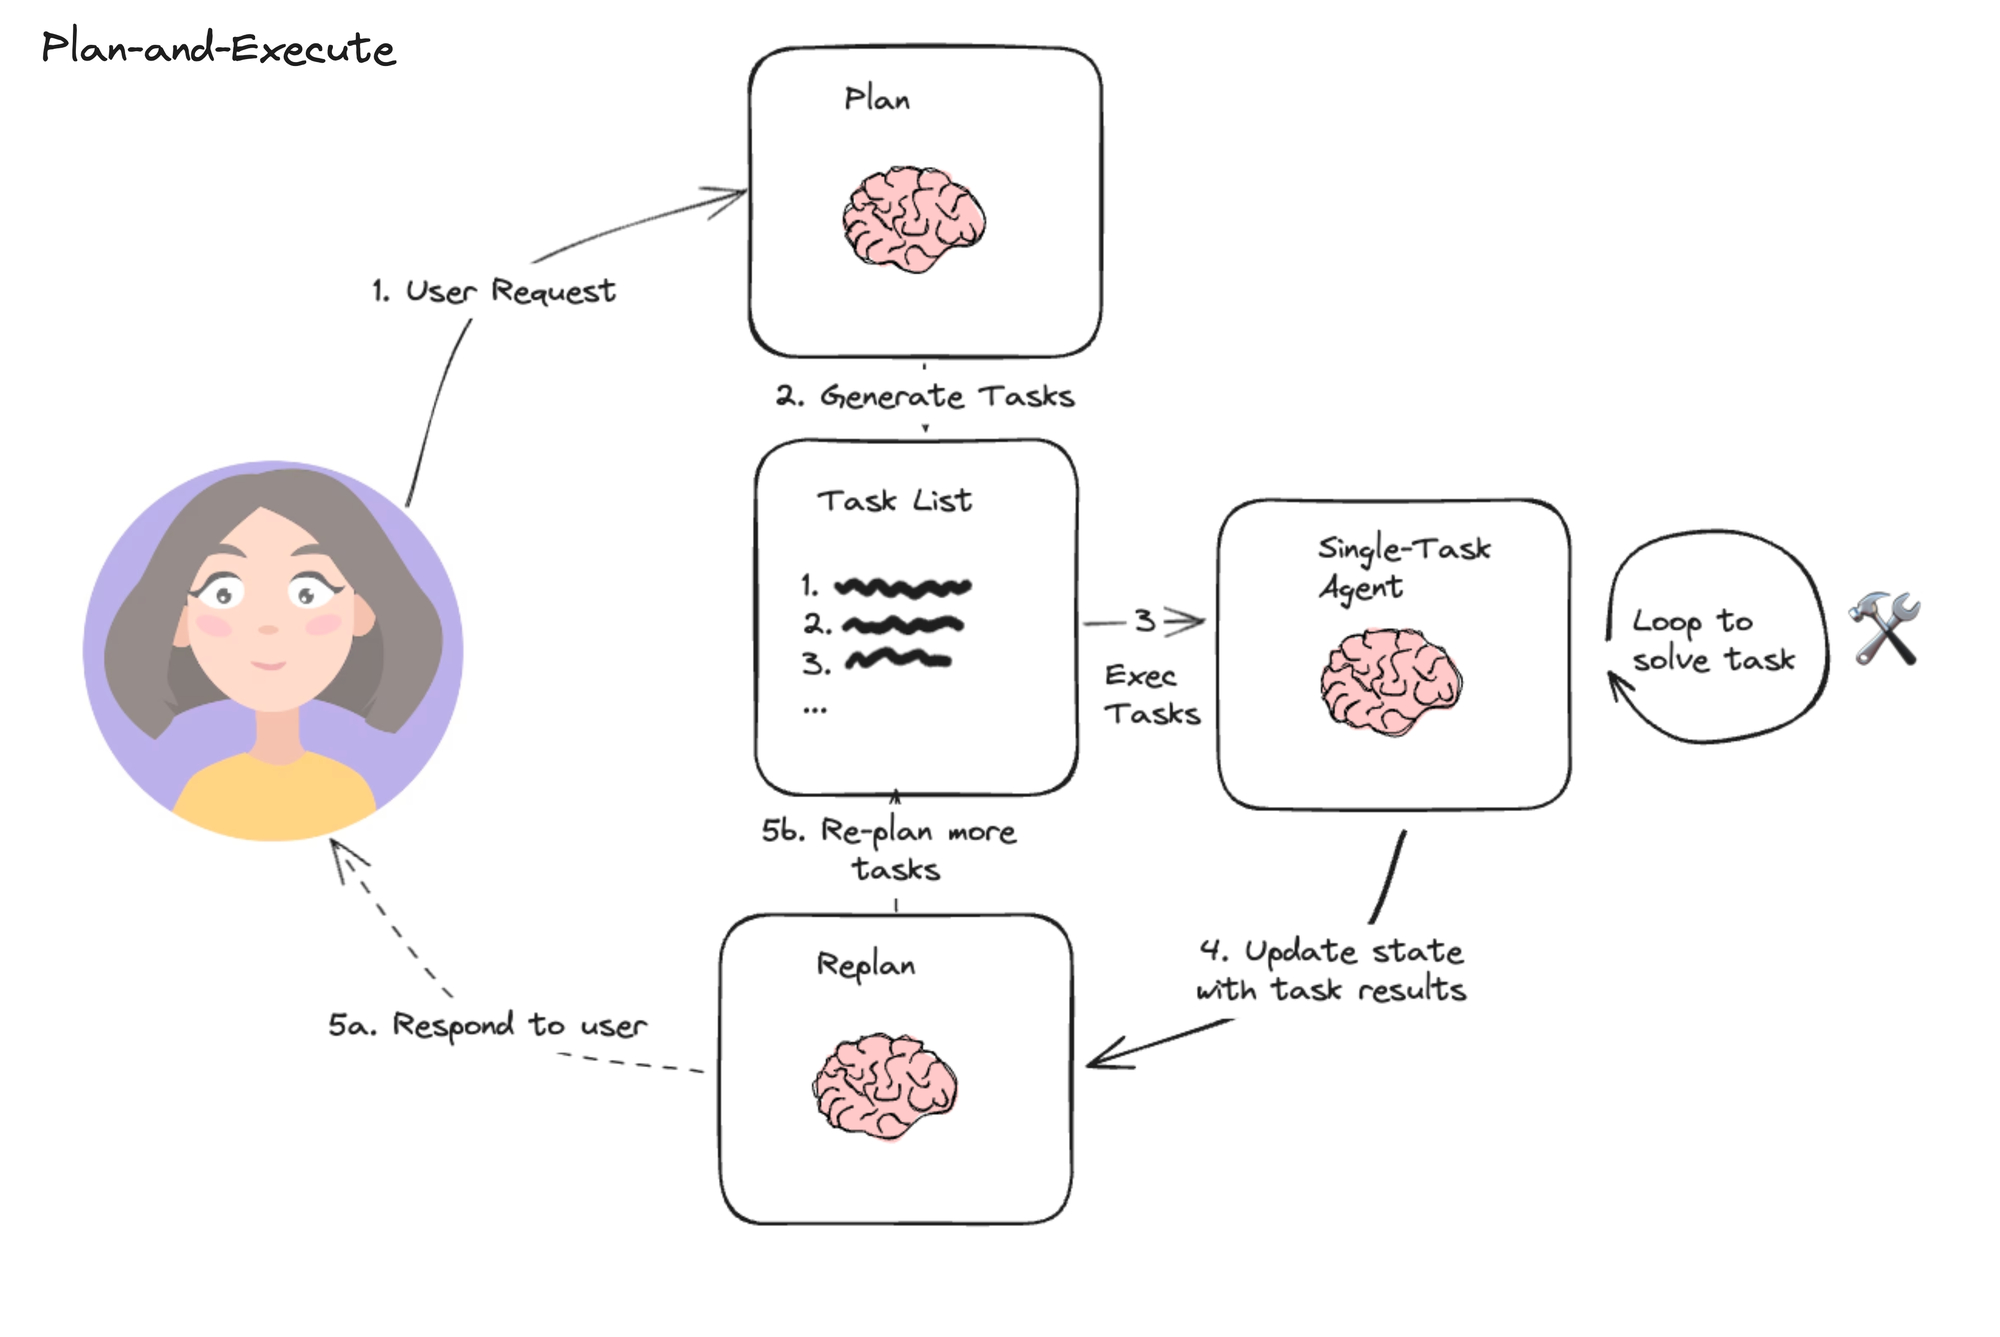

The advantages of this "plan-and-execute" style agent are:

- Explicit long term planning (which even really strong LLMs can struggle with) 
- Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step

### Setup

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

### Define Tools    

In [3]:
## We are only using 1 tool but multiple tools can be added here as an array

from langchain_community.tools.tavily_search import TavilySearchResults
tools = [TavilySearchResults(max_results=3)]


### Define Execution Agents

In [ ]:
from langchain import hub
from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = AzureChatOpenAI(
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_deployment=os.getenv("AZURE_DEPLOYMENT"),
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
)
agent_executor = create_react_agent(model=llm, tools=tools, state_modifier=prompt)

In [5]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [ ]:
inputs = {"messages": [("user", "Who won tennis mens US open in 2024? ")]}
print_stream(agent_executor.stream(inputs, stream_mode="values"))

### Define State

Plan-and-execute state holds memory of the AI agents. It has an input string, a plan generated by the main LLM as a list, plan steps as a list of Tuples which would contain the executed step and its result and lastly the response. 

In [7]:
import operator 
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### Planning Step

In [ ]:
# pydantic is a data model validation library and will ensure that the steps attribute is indeed a list of strings, and it will raise an error if the data does not conform to this specification. 

from pydantic import BaseModel, Field

class Plan(BaseModel):
    """Plan to follow in the future"""
    
    steps: List[str] = Field(description="Steps to follow in sorted order")

In [9]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps."""
        ),
        (
            "placeholder", "{messages}"
        ),
    ]
)

planner = planner_prompt | AzureChatOpenAI(
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_deployment=os.getenv("AZURE_DEPLOYMENT"),
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
    temperature=0,
).with_structured_output(Plan)

In [ ]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

### Re-plan Step

In [11]:
from typing import Union

class Response(BaseModel):
    """Response to user."""

    response: str
    
class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

replanner = replanner_prompt | AzureChatOpenAI(
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_deployment=os.getenv("AZURE_DEPLOYMENT"),
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
    temperature=0,
).with_structured_output(Act)


### Create Graph

In [12]:
from typing import Literal

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan: {plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }
    
async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}
    
def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [13]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)